# Histogram/Wedge Plot
***

By Nadia Steyn

This notebook plots a histogram with a corresponding wedge on the same x-axis scale. The x-axis represents velocity and theta represents RA.
The wedge is contructed from scratch and can be a maximum of RA = 90 degrees. One or two data sets can be included.

In particular, the code below plots the visual detections and SOFIA detections from MK16 Mosaic1.

Note: This code is relatively generalised, but I'm working on a script that is more generalised and has more options for the appearance of the wedge.

*Credit to Trystan for helping with the wedge_transform function & for loops.*

In [27]:
# Import statements
import numpy as np 
import pylab as plt
%matplotlib inline

# Reading in the catalogs

In [28]:
# Visual catalogue (txt or ascii):
infile = '/Users/nadia/data/mosaic1_visual-dets_c_SOFIA2_3Jun20.txt' # Change file directories to your own

### Second catalogue (optional - if you only have one file, comment out code marked with ###)
infile2 = '/Users/nadia/data/mosaic1_cat_final.txt' # SOFIA list

# Creating variables

In [29]:
# File 1 (visual catalog)
# create variables RA, Dec and Vel (if you have a variable other than Vel, adjust accordingly):
# In my txt file, columns 3-8 has ra/dec & column 9 has velocity
RA_h, RA_m, RA_s, Dec_d, Dec_m, Dec_s, Vel = np.loadtxt(infile, unpack=True, usecols=range(3,10))
RA = (RA_h + RA_m/60 + RA_s/(60*60)) * (360/24) # transforming h:m:s to degrees
Dec = (Dec_d - Dec_m/60 - Dec_s/(60*60)) # transforming d:m:s to degrees

# File 2 (SOFIA catalog) 
### Comment out if you don't have a 2nd file
ra_sof, dec_sof, vopt_sof = np.loadtxt(infile2,usecols=(34,35,36),unpack=True)
vopt_sof = vopt_sof*1e-3 # converting from m/s to km/s

# Defining the grid for the wedge

In [30]:
# spokes of the wheel
theta_min = 120 # lowest RA you wish to have on the wedge (degrees)
theta_max = 140 # highest RA you wish to have on the wedge (degrees)
theta_binwidth = 5
theta_range = np.arange(theta_min, theta_max+theta_binwidth, theta_binwidth)

# rings of the wheel
r_min = 0 # start velocity (km/s)
r_max = 25000 # end velocity (km/s)
r_binwidth = 1000 # km/s
r_range = np.arange(r_min,r_max+r_binwidth,r_binwidth) # Returns an array with evenly spaced elements

# Create function for transforming RA, Vel to cartesian coordinates

In [31]:
faq = (np.pi/180) # variable for converting to radians
offset = -theta_max # variable to rotate the wedge to line up with the x-axis (at 270 degrees)

def wedge_transform(RA, Vel, offset) :
    x = Vel*np.cos(faq*(RA+offset))
    y = Vel*np.sin(faq*(RA+offset))
    
    return x,y

# Making the plot

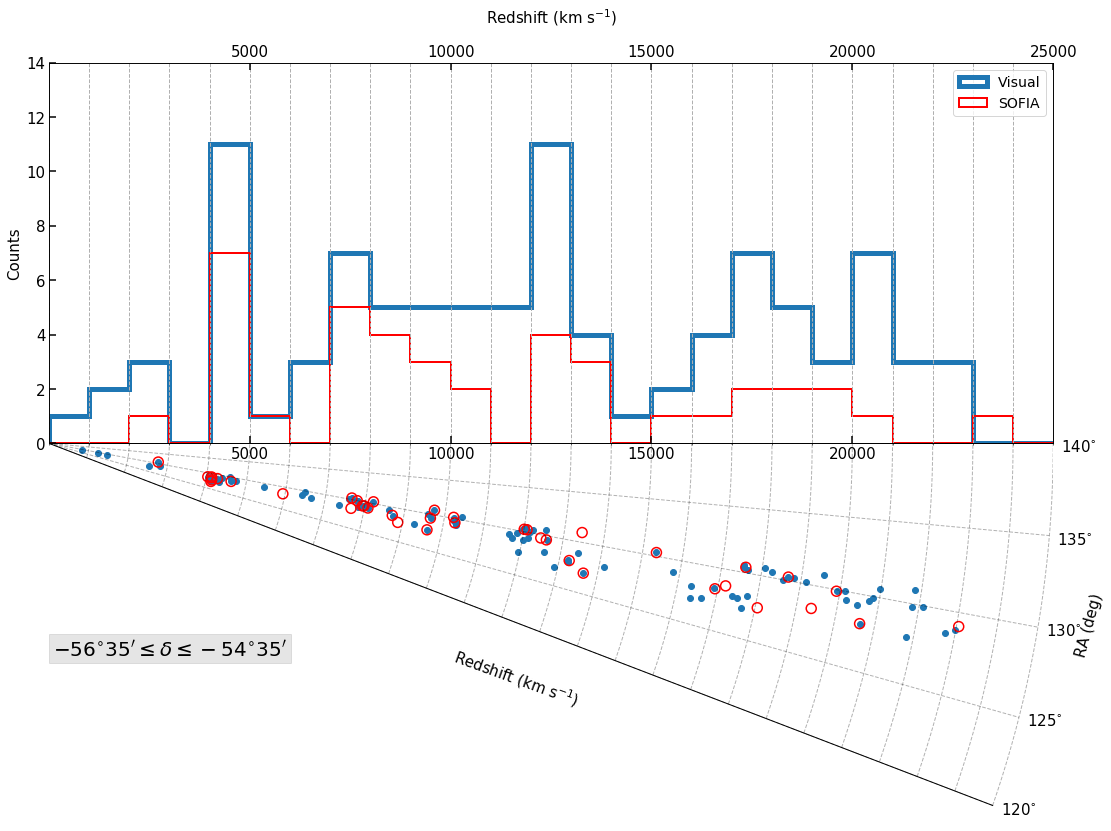

In [32]:
# Defining the two subplots
fig = plt.figure() 
ax1 = fig.add_subplot(212)
ax2 = fig.add_subplot(211)
fig.subplots_adjust(hspace=0) 

# Plotting the 'spokes'
grid_r = np.linspace(r_min,r_max,100000)
for i in range(len(theta_range)):
    grid_theta = np.ones(len(grid_r))*theta_range[i]
    x,y = wedge_transform(grid_theta, grid_r, offset)
    ax1.plot(x,y,ls='--',c='k',alpha=0.3,lw=1)
    
    # Adding labels at the end of each spoke
    ax1.text(x[-1]+200,y[-1]-200,str(theta_range[i])+'$^{\circ}$',fontsize=15) 
    
# Plotting the 'rings'
grid_theta = np.linspace(theta_min,theta_max,100000)
for i in range(len(r_range)):
    grid_r = np.ones(len(grid_theta))*r_range[i]
    x,y = wedge_transform(grid_theta, grid_r, offset)
    ax1.plot(x,y,ls='--',c='k',alpha=0.3,lw=1)

# Plot only the wedge around the data (instead of a full circle)
zoomed_lines = np.array([theta_min,theta_max])
grid_r = np.linspace(r_min,r_max,100000)
for i in range(len(zoomed_lines)):
    grid_theta = np.ones(len(grid_r))*zoomed_lines[i]
    x,y = wedge_transform(grid_theta, grid_r, offset)
    ax1.plot(x,y,c='k',linewidth=1)
    

# Adding File1 histogram
bins = r_range
ax2.hist(Vel, histtype='step', bins=bins, lw=5, label='Visual')

### Adding File2 histogram (comment out if you only have File1)
ax2.hist(vopt_sof, histtype='step', color='r',bins=bins, lw=2, label='SOFIA')

# Plotting the File1 data points in the wedge
x,y = wedge_transform(RA, Vel, offset)  
ax1.scatter(x,y)

### Potting the File2 data points in wedge (comment out if you only have File1)
x,y = wedge_transform(ra_sof, vopt_sof, offset) 
ax1.scatter(x,y,facecolors='none',s=100, edgecolors='r', lw=1.5)

# Ghost data
# ON: WEDGE ANGLE WILL BE CONSERVED
# OFF: WEDGE WILL BE STRETCHED TO FILL THE SUBPLOT REGION (~20 DEG)
# The final appearance of the wedge can also be adjusted by changing the figsize at the end
ghost_x,ghost_y = wedge_transform(np.arange(0,360,1),r_max*np.ones(len(np.arange(0,360,1))),0)
#ax1.scatter(ghost_x,ghost_y,alpha=0.0)

# Ax1 adjustments
ax1.set_xlim(left=0,right=r_max) # moving the wedge to the top left corner of the axes
ax1.set_ylim(top=0)
ax1.axis('off')

# Ax1 labels
##### NB: If your wedge is anything other than 40 degrees, you'll have to move the labels! #####
ax1.text(10000,-6200,'Redshift (km s$^{-1}$)',fontsize=15, rotation=theta_min-theta_max) # Velocity label
ax1.text(25500,-5000,'RA (deg)',fontsize=15, rotation=75) # RA (deg) label
# Add the Dec label (in this case, Dec range = -56d35m --> -54d35m):
ax1.text(100,-5000,r"$-56^{\circ}35' \leq \delta \leq -54^{\circ}35'$", fontsize=20, \
         rotation=0, bbox=dict(facecolor='k',alpha=0.1)) 

# Ax2 adjustments / labels
ax2.legend(fontsize=14)
ax2.tick_params(direction="in", length=7, width=1.5)

# Histogram axes labels
ax2.set_xlabel("Redshift (km s$^{-1}$)", fontsize=15,labelpad=40)
ax2.set_ylabel("Counts", fontsize=15)
ax2.set_xlim(r_min,r_max)
ax2.set_ylim(bottom=0.)
ax2.set_yticks(np.arange(0, 14+1, 2.0)) # adjust according to your counts
plt.tick_params(axis='both',labelsize=15)
ax2.xaxis.set_label_position('top')

# Add grid to histogram
major_ticks = np.arange(5000,25000,5000)
minor_ticks = r_range # size of the bins
ax2.set_xticks(major_ticks)
ax2.set_xticks(minor_ticks,minor=True)
ax2.grid(which='both',ls='--',lw=1)
ax2.yaxis.grid()
ax2.set_axisbelow(True) # move grid to back

# Top x-axis labels
ax3 = ax2.twiny()
x2tick_location = ax2.xaxis.get_ticklocs()
major_ticks = np.arange(5000,30000,5000)
ax3.set_xticks(major_ticks)
plt.tick_params(axis='x',labelsize=15)
ax3.set_xticklabels(major_ticks)
ax3.tick_params(direction="in", length=7, width=1.5)

fig.set_size_inches(18, 14, forward=True) # Change fig size to your liking
plt.savefig('test.png') # Name your image
plt.show()